In [ ]:
# ------------------------------------------------------------------------------
# Authors: Andreas Nilsson, Anouka Ranby, Erik Rosvall (All part of ADS program)
# Date: 23 Jan 2022
# Description: Decision Trees - Applied Machine Learning, DIT867
# ------------------------------------------------------------------------------

### Task 2: Decision trees for classification

Download the code that was shown during the lecture and use the defined class TreeClassifier as your classifier in an experiment similar to those in Task 1, using the same dataset (Alternatively, you can create a new notebook and copy the code from this page).

**Tune the hyperparameter max_depth to get the best cross-validation performance, and then evaluate the classifier on the test set.**

For the report. In your submitted report, please mention what value of max_depth you selected and what accuracy you got.

For illustration, let's also draw a tree. Set max_depth to a reasonably small value (not necessarily the one you selected above) and then call draw_tree to visualize the learned decision tree. Include this tree in your report.

In [ ]:
from sklearn import datasets
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Below we have the components needed to implement decision tree classifiers and regression models: DecisionTreeLeaf and DecisionTreeBranch.

A leaf corresponds to the base case of a recursion. It is a "dummy" tree that always returns a constant value.

In [ ]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value # e.g. flower class of iris, or owns a car/not own car

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

A branch will look at one feature, and will select a subtree depending on the value of the feature. That subtree will then be called recursively to compute the prediction.

This implementation assumes that the feature is numerical. Depending on whether the feature is or isn't greater than a threshold, the "high" or "low" subtree will be selected.

In [ ]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x): # x is the feature value to look at
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

Following standard practice in scikit-learn, we inherit from the class BaseEstimator, which is the base class of all classifiers and regression models:

In [ ]:
!pip install graphviz

     |████████████████████████████████| 46 kB 6.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from graphviz import Digraph
from abc import ABC, abstractmethod # import abstract class for DecisionTree and abstract method for functions

We write the DecisionTree class as an abstract class that contains the functionality common to all types of decision trees. Classification and regression models will later below be implemented as subclasses. 

The classification subclass is given below, while the regression subclass will be implemented as a part of the first assignment. Following scikit-learn naming conventions, we'll call the training and prediction methods fit and predict, respectively.

In [ ]:
# general decision tree algo that can be inherited by both regression and classification subclasses
class DecisionTree(ABC, BaseEstimator): 

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth ## MAX DEPTH ##
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training - X and Y will also be subsets of data after splits
    def make_tree(self, X, Y, max_depth):

        # DIFFERENT FOR CLASSIFICATION / REGRESSION
        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        ## MAX DEPTH ##
        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0: # FIRST TERMINATION CASE - reaching max depth
            return DecisionTreeLeaf(default_value)

        # DIFFERENT FOR CLASSIFICATION / REGRESSION
        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y): # SECOND TERMINATION CASE - when all y values are the same no need to go further
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold (if numerical value in feature). 
        # To rank the "usefulness" of features, we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    # DIFFERENT FOR CLASSIFICATION / REGRESSION
    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

The functions that the subclasses will need to implement, and which are done differently for classification and regression, are the following:

- get_default_value: what output value to use if we decide to return a leaf node. For classification, this will be the most common output value, while for regression it will be the mean.
- is_homogeneous: tests whether a set of output values is homogeneous. For classification, this means that all outputs are identical; for regression, we'll probably test whether the variance is smaller than some threshold.
- best_split: finds the best splitting point for that feature. For classification, this will be based on one of the classification criteria (information gain, gini impurity, majority sum); for regression, it will be based on variances in the subsets.

Below is the subclass that implements decision tree classification. This implementation makes heavy use of the Counter class, which is a standard Python data structure for frequency counting.

In [ ]:
class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=50, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1 #returns True or False
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

Here, we define the various criteria we can use to find the "quality" of a split in terms of how homogeneous the subsets are. See the reading material for the mathematical definitions of these criteria:

In [ ]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

Here we implement the Decision Tree for Classification using the data set CTG to predict a diagnosis type following the FIGO Intrapartum Fetal Monitoring Guidelines: **normal, suspicious, or pathological**.


In [ ]:
# Read the CSV file.
data = pd.read_csv('CTG.csv', skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
def best_model_depth(min_d, max_d, Xtrain, Ytrain, Xtest, Ytest):
    """
    Tests different depth of tree and returns model, 
    along with accuracy scores for test and train for all depths
    """
    # empty lists to store accuracy score for train and test
    scores_train = [] 
    scores_test = []
    
    #test depth between 1-10 (inclusive)
    for i in range(min_d, max_d): 
        model = TreeClassifier(max_depth=i) #create object from class
        model.fit(Xtrain, Ytrain) #train (fit) the model with training data

        # cross_validate with n folds and get mean accuracy score from all folds
        cvs = cross_validate(model, Xtrain, Ytrain, cv=5, scoring='accuracy')
        acc_train = cvs['test_score'].mean()
       
        all_predictions = model.predict(Xtest) #predict with model on unseen test data
        acc_test = accuracy_score(Ytest, all_predictions) # check accuracy score for test

        scores_train.append(acc_train)
        scores_test.append(acc_test)
    
    return scores_train, scores_test


min_d = 1 #min tree depth
max_d = 21 #max tree depth

train_scores, test_scores = best_model_depth(min_d, max_d, Xtrain, Ytrain, Xtest, Ytest)
#print("Test accuracies:\n",test_scores)
#print("Train accuracies:\n",train_scores)
print("---\nBest Accuracy score for Test data was",max(test_scores),"with a max depth of",test_scores.index(max(test_scores))+1)

---
Best Accuracy score for Test data was 0.8896713615023474 with a max depth of 4


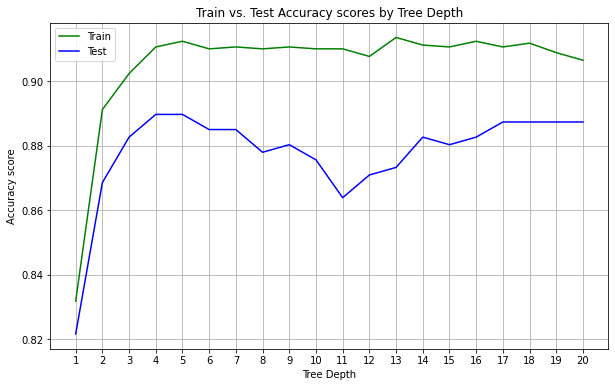

Best Accuracy score for Test data was 0.8896713615023474 with a max depth of 4


In [ ]:
def plot_train_test_accuracy(min_range, max_range, train_scores, test_scores):
    plt.figure(figsize=(10,6))
    plt.plot(range(min_range,max_range), train_scores, label = "Train", color='green')
    plt.plot(range(min_range,max_range), test_scores, label = "Test", color='blue')
    plt.title("Train vs. Test Accuracy scores by Tree Depth")
    plt.xlabel("Tree Depth")
    plt.ylabel("Accuracy score")
    plt.legend()
    plt.xticks(range(min_range,max_range,1))
    plt.grid()
    plt.show()

plot_train_test_accuracy(min_d, max_d, train_scores, test_scores)
print("Best Accuracy score for Test data was",max(test_scores),"with a max depth of",test_scores.index(max(test_scores))+1)

##### Comments:

Here we are testing different values of max depth between 1 and 20 to learn the performance of training and test data using the evauation metric accuracy and cross validation with 5 folds on the training data. 

The best performance we achieve for the unseen test data is when we have the maximum tree depth set to 4 resulting in the highest accuacy score at nearly 89%. For illustration purposes when drawing the tree we'll use max depth of 3 levels to make it smaller. 

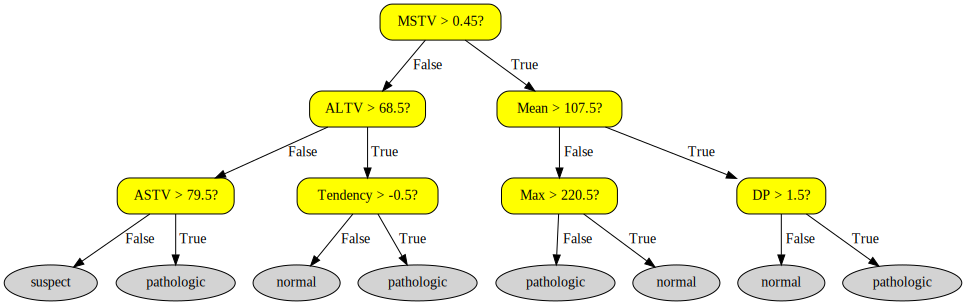

In [ ]:
final_model = TreeClassifier(max_depth=3) #create object from class
final_model.fit(Xtrain, Ytrain)
final_model.draw_tree()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a6ba0eaf-97fa-4fd0-ab2f-858132e990c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>